## Modeling of Measurement Uncertainty of a high-dimensional RNA-Seq classifier of cell-free mRNA for Alzheimer’s Disease


### Author: Deb Debnath

### Motivation

The main reasons for ‘clinical-grade’ measurement uncertainty
usefulness include:

- improved understanding of test interpretation;
- operational tool to discern laboratory test drift;
- sheds light on the analytes that should be prioritized to decrease overall uncertainty range and;
- upon request, laboratories must make estimates of measurement uncertainty available to laboratory users.

### Goal

Using modeled simulation of high dimensional RNA-Seq, can we estimate inherent empirically informed measurement uncertainties in an illustrative AD classifier?

### Measurement Uncertainty: Regulatory Setting

- Clinical Laboratory Standards Institute (CLSI)
    - CLSI EP29-A Expression of Measurement Uncertainty in Laboratory Medicine
- International Standards Organization (ISO)
    - ISO 15189-2012
    - ISO/TS 20914:2019
- Food and Drug Administration (FDA)
    - Class II Special Controls Guidance Document: Ovarian Adnexal Mass Assessment Score Test System (2011).

Monte Carlo techniques are recommended by FDA to estimate diagnostic uncertainty of multi-dimensional classifiers. Overall uncertainty of high dimensional classifiers can be determined or estimated. Besides noted variation, sample site, operator and instrument variation need to be considered. \
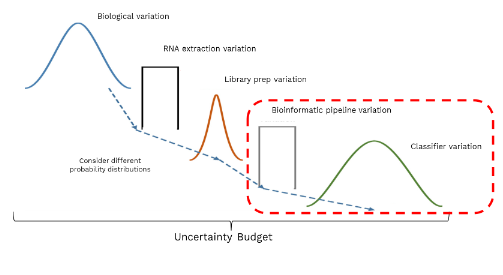

### Background 

The ML model used in this notebook is a classifier from a study published in _Science Advances_ ([Toden et al, 2020](https://www.science.org/doi/abs/10.1126/sciadv.abb1654)). The study utilized plasma-derived circulating cell-free messenger RNA (cf-mRNA) from a dataset comprising 126 patients with Alzheimer's Disease (AD) and 116 healthy, non-cognitive impairment (NCI) controls of similar age distribution, sourced from five independent academic centers and one commercial provider; pre-analytic site-specific effects were adjusted for in subsequent analyses. 

To prepare the machine learning model for AD classification while minimizing bias, feature selection was conducted exclusively on samples from a distinct training cohort (University of Kentucky: 24 NCI and 66 AD patients). This involved identifying differentially expressed genes using DESeq2 with a false discovery rate (FDR) cutoff of less than 0.05.

The machine learning model, a logistic regression with L2 regularization, was trained using the expression levels (transcripts per million) of these 1658 selected genes from the University of Kentucky training cohort (24 NCI, 66 AD). L2 regularization was specifically employed to prevent overfitting. Metaparameters for this model were optimized using a 15-fold cross-validation strategy on the training cohort. 

The classifier's ability to discriminate between AD patients and NCI controls was then rigorously evaluated on an independent test set. This test set consisted of the remaining 60 AD patients and 92 NCI controls, derived from four independent sources distinct from the training data (UC San Diego, University of Washington, Indiana University, BioIVT). In this independent validation, the classifier achieved an Area Under the Receiver Operating Characteristic curve (AUC) of 0.83. Further analysis revealed that the genes included in the classifier were enriched in biological pathways known to be associated with AD pathogenesis, including immune response and cellular metabolic processes, thereby lending biological plausibility to the statistical findings

Reference table from _Wimo et al (2014)_
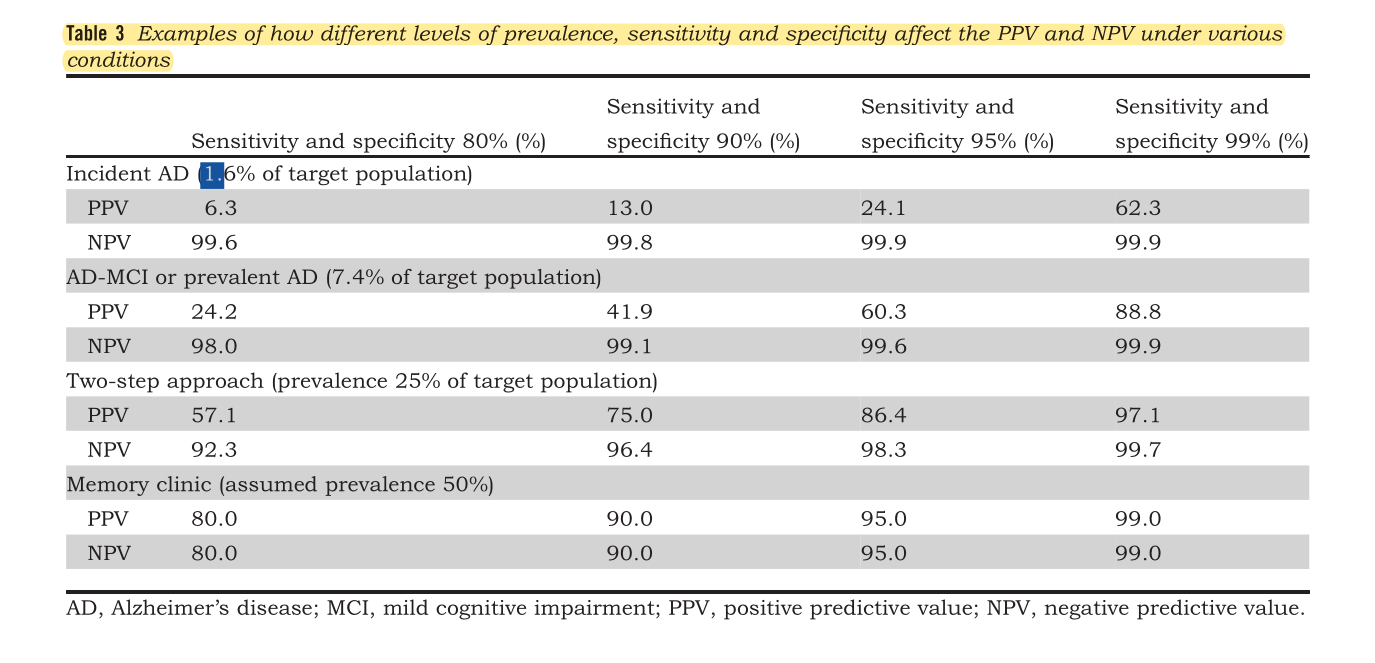

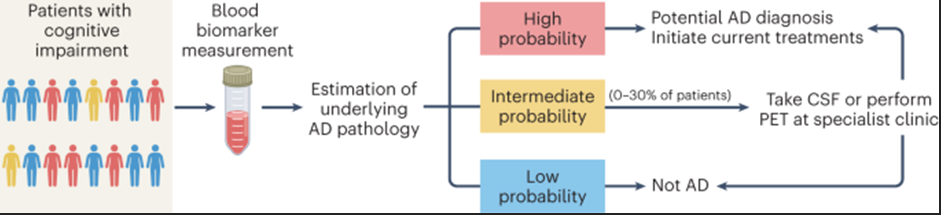

### Imports

In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from src.postprocessing import (
    build_sensitivity_specificity_df,
    calculate_subject_wise_agreement,
    calculate_subject_wise_disagreement,
    get_threshold,
    plot_v_plot,
    generate_waterfall_plot,
    plot_differential_classification_results,
)
from src.logreg_classifier import antilogit_classifier_score
from src.simulation import MultiUncertaintyResults, simulate_multiple_uncertainties
from src.dtypes import NumpyFloat32Array1D

#### Data loading

The `raw_data` dataframe contains the TPM values for 243 subjects (including technical replicates), along with the coefficients of the classifier. The `pathos` dataframe contains the original categories that the patients belong to.

In [3]:
data_root = Path.cwd().parent.parent / "raw_data"
raw_data = pd.read_excel(
    data_root / "ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    data_root / "ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)

In [4]:
raw_data.head()

,gene_id,11174-r1,11178-r1,11182-r1,11182-r2,11186-r1,11186-r2,11190-r1,11190-r2,11194-r1,...,5767-r1,5767-r2,5784-r1,5784-r2,Description,ORI,MIN,MAX,AVG,Coeff
0,ENSG00000079482.12,40.167869,43.221009,102.123100,82.137419,59.941767,13.792904,72.000992,56.627618,68.009413,...,12.370367,2.007663,10.735082,9.461999,OPHN1,1463,0.636022,918.081706,54.796436,0.399459
1,ENSG00000169021.5,4.669515,8.401576,6.827512,9.261443,11.148535,4.445162,5.426358,3.210182,9.386716,...,17.178199,15.817280,11.460425,17.641014,UQCRFS1,12353,0.000000,22.361685,10.534654,0.372143
2,ENSG00000204160.11,91.808686,52.448546,105.386495,48.958301,32.223227,33.497053,29.494519,30.000614,71.504342,...,55.816251,25.256624,58.390142,36.782660,ZDHHC18,17522,4.339465,625.797208,60.139569,0.356649
3,ENSG00000106780.8,44.561230,8.633877,19.836541,21.810697,9.518698,5.770501,9.937019,4.144054,13.294896,...,12.566394,16.028029,15.729589,12.027964,MEGF9,3337,0.836062,151.685905,15.425324,0.311521
4,ENSG00000113303.11,3.803395,2.503695,10.826006,3.646693,7.922817,0.000000,5.855945,5.544861,8.926236,...,0.804744,3.704749,4.051561,0.893506,BTNL8,4136,0.000000,61.493366,5.592945,0.301690


In [5]:
pathos.head()

,Isolate ID,Disease
0,1817.0,NCI
1,1818.0,NCI
2,1821.0,NCI
3,1850.0,NCI
4,1854.0,NCI


For convenience we set the index to the specified columns.

In [6]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

#### Setting parameters

Here we set some parameters that we will use throughout the analysis.

In [7]:
master_seed = 123  # Random number seed
num_parallel_workers = 8  # Number of parallel jobs to run for simulation

In [8]:
num_patients = 243  # Total number of samples/subjects/patients

In [9]:
mean_TPM = 10  # When we filter genes for analysis with a reduced feature set,
# we drop genes for which the mean TPM is below this cutoff

In [10]:
n_samples = 1000  # Number of Monte Carlo samples to simulate for each subject
uncertainties = list(
    range(5, 40, 5)
)  # Maximum percentage of noise/uncertainty to simulate. (aka coefficient of variation)

#### Data preprocessing

In [11]:
pathos = pathos.dropna()
pathos = pathos.loc[pathos.index.dropna(), :]
pathos.index = pathos.index.astype(int).astype(str)

In [12]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

The raw dataset contains technical replicates for some subjects. We average the technical replicates to reduce them to a single data point.

In [13]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

In [14]:
for col in patients_df.columns:
    if col not in pathos.index:
        print(col)

17906


In [15]:
for col in pathos.index:
    if col not in patients_df.columns:
        pathos = pathos.drop(col)

In [16]:
# Assuming NCI for 17906 (missing from pathos data)
pathos.loc["17906"] = "NCI"

In [17]:
patients_df = patients_df.loc[:, pathos.index]

#### Dropping genes below TPM threshold

When analysing a dataset with a reduced set of genes, we keep the genes where the mean TPM value is above the specified cutoff. If the `mean_TPM` value is set to zero, no genes are filtered and the entire dataset is used.

In [18]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [19]:
coefficients = coefficients[means >= mean_TPM]
patients_df = patients_df[means >= mean_TPM]

### Sensitivity and Specificity

In [20]:
_z_scores = (
    patients_df.values - patients_df.mean(axis=1).values.reshape(-1, 1)
) / patients_df.std(axis=1).values.reshape(-1, 1)
gt_probs = antilogit_classifier_score(
    np.sum(coefficients[:, np.newaxis] * _z_scores, axis=0)
)
gt_probs = pd.Series(index=patients_df.columns, data=gt_probs)

In [21]:
single_thres = get_threshold(70, build_sensitivity_specificity_df(pathos, gt_probs, "AD")) / 100
dual_thres_low = get_threshold(93, build_sensitivity_specificity_df(pathos, gt_probs, "NCI")) / 100
dual_thres_high = get_threshold(70, build_sensitivity_specificity_df(pathos, gt_probs, "AD")) / 100
print(f"{single_thres=} {dual_thres_low=} {dual_thres_high=}")

single_thres=np.float64(0.86) dual_thres_low=np.float64(0.08) dual_thres_high=np.float64(0.86)


### Performing Monte Carlo simulations

We follow established guidance by the FDA ([Ovarian Adnexal Mass Assessment Score system (2011)](https://www.fda.gov/medical-devices/guidance-documents-medical-devices-and-radiation-emitting-products/ovarian-adnexal-mass-assessment-score-test-system-class-ii-special-controls-guidance-industry-and)) in simulating technical variation in the TPM values.

In general, given a measurement $\mu$, to simulate $k$ % uncertainty ($k$% coefficient of variation/relative standard deviation) we sample from a Gaussian distribution with mean $\mu$ and standard deviation (SD) $kX/100$.

However, for RNA-seq datasets, modeling uncertainty in this fashion with a constant noise level ignores the trend of technical variation commonly observed (e.g. in Fig. 1.(a) from [Law et al (2014)](https://link.springer.com/content/pdf/10.1186/gb-2014-15-2-r29.pdf)).
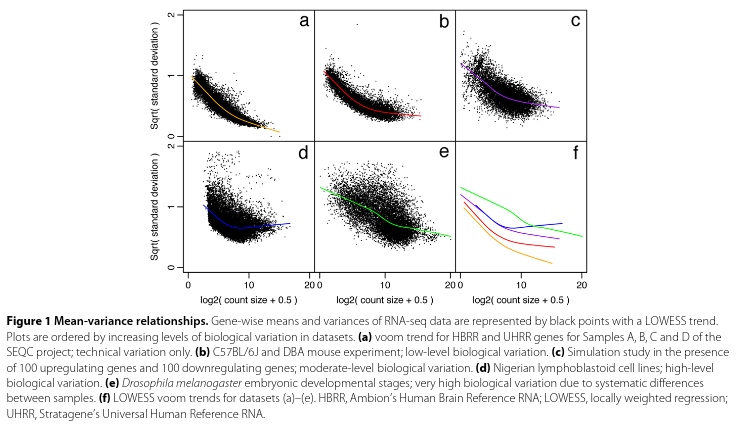

Aligning with Law et al (2014), the relationship between the standard deviation and the mean can be modeled as

$$
\sqrt{\sigma} = \frac{a}{b + \mu} + c
$$

where $\mu$ and $\sigma$ are mean and standard deviation of the $log_2 (1+TPM)$ dataset, respectively and $a$, $b$, $c$ are constants.\\

We start with values of $a$ = 0.75, $b$ = 1.0, $c$ = 0.25, $scaling factor$ = 8.

To generate Monte Carlo TPM samples for a given gene $i$ and subject $j$:

1. Calculate $\sigma_{ij}$ using the SD-mean relationship with $TPM_{ij}$ as the mean:

$$\mu_{ij} = log_{2}(1 + TPM_{ij})$$

$$\sigma_{ij} = (\frac{a}{\mu_{ij} + b} + c)^2$$

$$\sigma_{ij, scaled} = \frac{scaling factor * k * \sigma_{ij}}{100}$$

2. Generate $N$ samples $x_k$ ($k$ = $1…N$) from a Gaussian distribution with mean = $\mu_{ij}$ and standard deviation = $\sigma_{ij}$, scaled.
3. Convert samples to TPM scale by exponentiation:
$$TPM_{k, sampled} = 2^{x_k}$$

In [22]:
def calculate_scaled_sd(
    tpm: float,
    uncertainty_pct: int | float,
    a: float = 0.75,
    b: float = 1.0,
    c: float = 0.25,
    scaling_factor: float = 8.0,
) -> float:
    r"""
    Calculate scaled standard deviation for a given TPM value and baseline
    uncertainty to simulate based on the equation
    $$
    \sqrt{\sigma} = \frac{a}{b + \mu} + c
    $$

    Parameters
    ----------
    tpm
        The TPM value to use as the input.
    uncertainty_pct
        The baseline percent uncertainty.
    a
        Constant for the calculation.
    b
        Constant for the calculation.
    c
        Constant for the calculation.
    scaling_factor
        Multiplier used to scale the SD from the equation.

    Returns
    -------
    float
        The scaled standard deviation value to use for generating simulated TPM
        values.
    """
    sqrt_sigma = a / (np.log2(tpm + 1) + b) + c
    scaled_pct_sd = scaling_factor * uncertainty_pct * sqrt_sigma**2.0
    return scaled_pct_sd / 100

After generating the simulated measurements we calculate the classifier predictions for these. We then compare the score for the simulated measurement ("simulated score") against the score for the actual measurement ("actual score"). Based on the set threshold(s) we track the classification of the simulated scores against the actual scores.

A **differentially classified subject** is a subject (patient) that has one or more simulated scores that produced a different classification into AD/NCI than the actual score. We track differentially classified subjects under two scenarios
1. at least one of the simulated scores is different from the actual score.
2. at least 10 % of the simulated scores is different from the actual score.

The two different definitions of differential classification track the performance of the classifier under a conservative and a relaxed definition of differential classification.

In [23]:
def sampler(
    tpm: float, baseline_rsd: float, n_points: int = 1000, seed: int | None = None
) -> NumpyFloat32Array1D:
    """
    Function to generate Monte Carlo TPM samples given a TPM value and a
    baseline uncertainty value.

    Parameters
    ----------
    tpm
        TPM value to generate simulated TPM values from.
    baseline_rsd
        Reference uncertainty value to calculate the scaled SD for the simulated
        TPM values. Must be between 0 and 1.
    n_points
        Number of simulated TPM values to generate. Defaults to 1000.
    seed
        Seed for random number generator. Default is None.

    Returns
    -------
    np.ndarray[tuple[int], np.dtype[np.float32]]
        1D numpy array of floating point values representing TPM samples.
    """
    rng = np.random.default_rng(seed)
    scaled_sd = calculate_scaled_sd(tpm, baseline_rsd * 100)
    return np.pow(2.0, rng.normal(np.log2(tpm + 1), scaled_sd, n_points))

In [24]:
res_1_diff_cls: MultiUncertaintyResults = simulate_multiple_uncertainties(
    patients_df,
    sampler,
    uncertainties,
    thres_low=dual_thres_low,
    thres_high=dual_thres_high,
    single_thres=single_thres,
    coefficients=coefficients,
    diff_class_lim=1,
    n_samples=n_samples,
    seed=master_seed,
    num_workers=num_parallel_workers,
)
res: MultiUncertaintyResults = simulate_multiple_uncertainties(
    patients_df,
    sampler,
    uncertainties,
    thres_low=dual_thres_low,
    thres_high=dual_thres_high,
    single_thres=single_thres,
    coefficients=coefficients,
    diff_class_lim=int(0.10 * n_samples),
    n_samples=n_samples,
    seed=master_seed,
    num_workers=num_parallel_workers,
)

### Visualization and post-processing

<Figure size 1600x600 with 0 Axes>

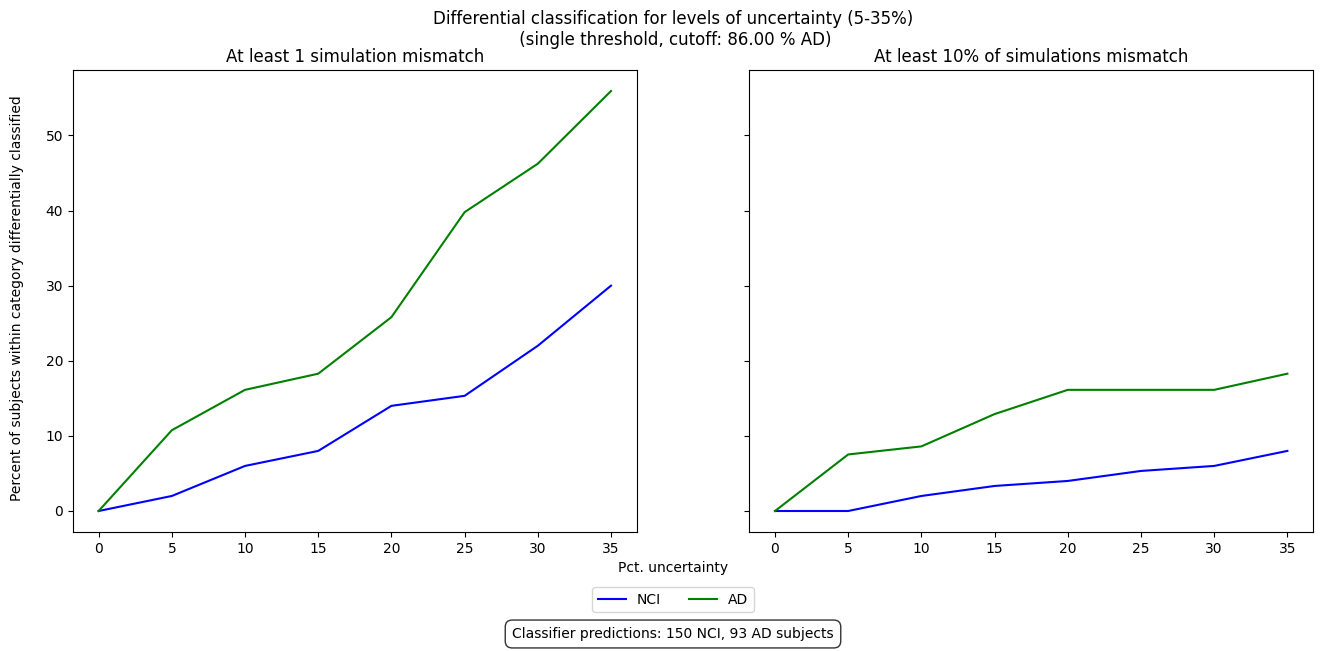

In [25]:
plot_differential_classification_results(
    gt_labels=res.single_thres_gt_labels,
    one_sim_mismatch_pred_labels_dict=res_1_diff_cls.single_thres_pred_labels,
    ten_pct_sim_mismatch_pred_labels_dict=res.single_thres_pred_labels,
    labels_dict=dict(zip(["NCI", "AD"], "bg")),
    figure_title="Differential classification for levels of uncertainty (5-35%)\n"
    + f" (single threshold, cutoff: {single_thres * 100:.2f} % AD)",
)

<Figure size 1600x600 with 0 Axes>

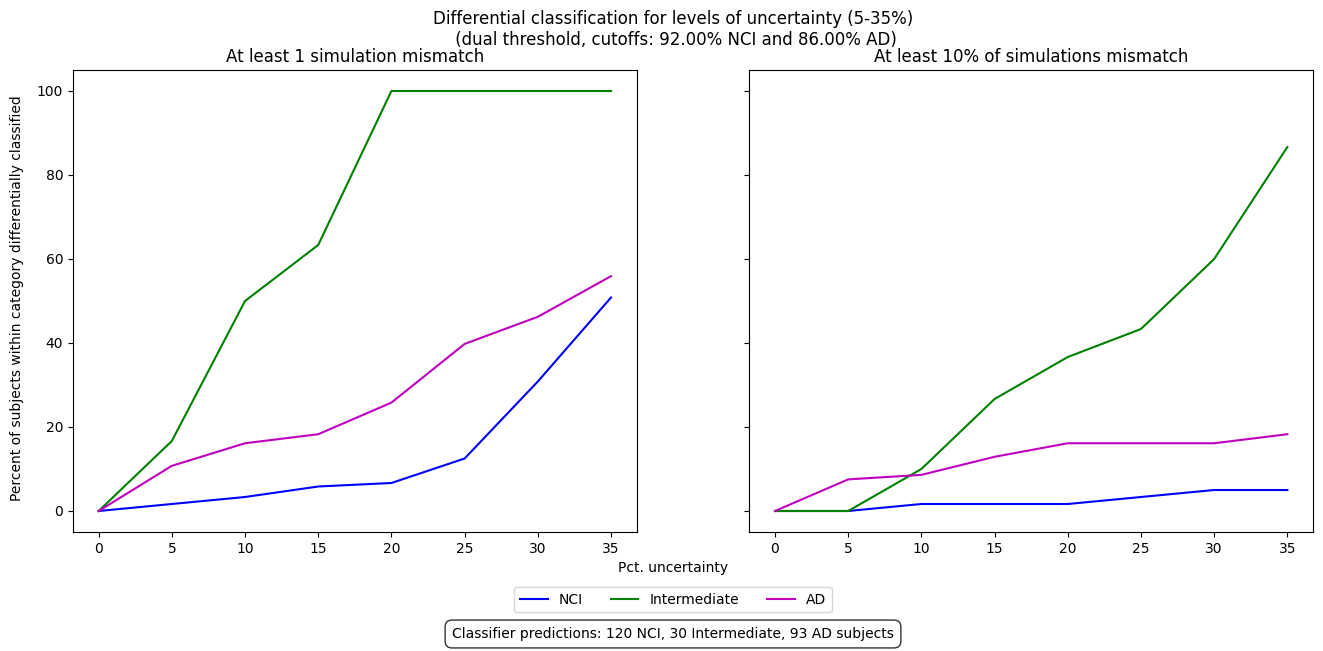

In [26]:
plot_differential_classification_results(
    gt_labels=res.dual_thres_gt_labels,
    one_sim_mismatch_pred_labels_dict=res_1_diff_cls.dual_thres_pred_labels,
    ten_pct_sim_mismatch_pred_labels_dict=res.dual_thres_pred_labels,
    labels_dict=dict(zip(["NCI", "Intermediate", "AD"], "bgm")),
    figure_title="Differential classification for levels of uncertainty (5-35%)\n"
    + f" (dual threshold, cutoffs: {(1 - dual_thres_low) * 100:.2f}% NCI and {dual_thres_high * 100:.2f}% AD)",
)

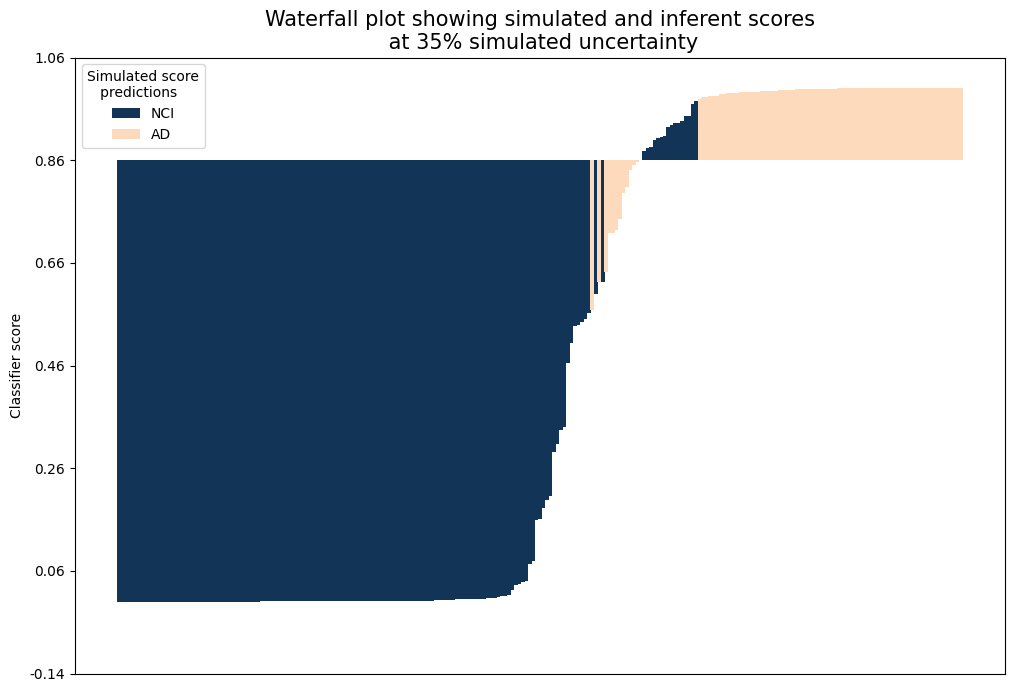

In [27]:
uncertainty = 35
generate_waterfall_plot(
    threshold=single_thres,
    probs=gt_probs,
    color_labels_data=res.single_thres_pred_labels[uncertainty],
    labels={0: "NCI", 1: "AD"},
    colors=["#123456", "#fedabc"],
    title=f"Waterfall plot showing simulated and inferent scores\n at {uncertainty}% simulated uncertainty",
    legend_title="Simulated score\n   predictions",
)

### Visualizing agreement between simulated and inferent scores

We calculate the classification agreement between methods in each part of the spectrum of disease severity using the **V-plot method** ([Petraco et al (2018)](https://openheart.bmj.com/content/openhrt/5/1/e000663.full.pdf)). 

The V-plot has this shape because the accuracy of tests is universally high at the extremes of disease severity (near 100%) but close to the classification cut-off agreement plunges. The width of the mouth of the V can be used as a general measure of a test’s performance: the wider the V, the poorer the test ability to match a reference modality. Classification agreement between two methods of measurement is called diagnostic accuracy if one test is considered the reference gold standard.

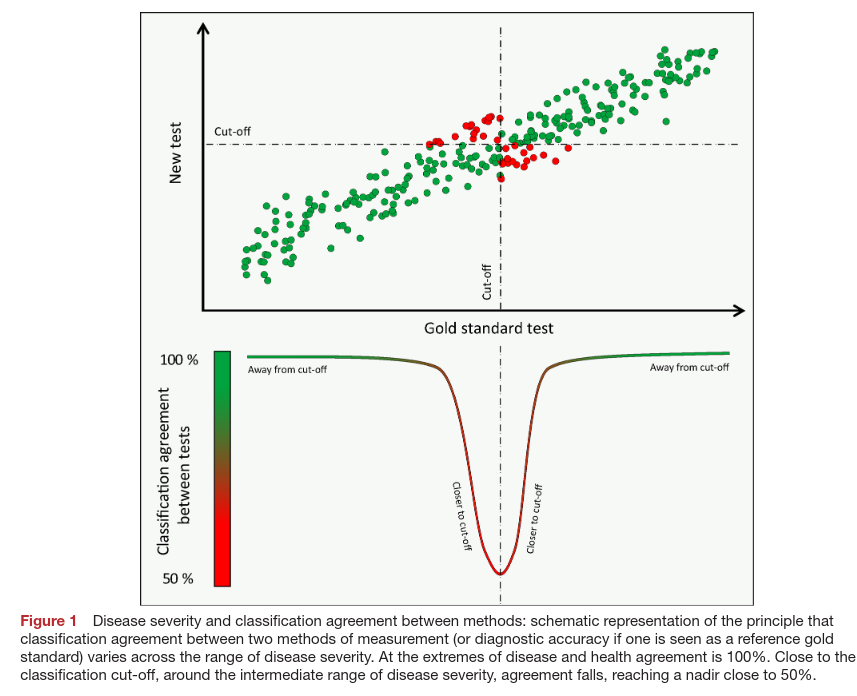


In [28]:
single_thres_subj_wise_agreement = calculate_subject_wise_agreement(
    gt_series_dict=res.single_thres_gt_series,
    pred_series_dict=res.single_thres_pred_series,
    uncertainties=uncertainties,
    n_samples=n_samples,
)
dual_thres_subj_wise_agreement = calculate_subject_wise_agreement(
    gt_series_dict=res.dual_thres_gt_series,
    pred_series_dict=res.dual_thres_pred_series,
    uncertainties=uncertainties,
    n_samples=n_samples,
)

In [29]:
categories = ["NCI", "Intermediate", "AD"]
gt_arr_dict, pred_arr_dict = res.dual_thres_gt_series, res.dual_thres_pred_series

In [30]:
dual_thres_subj_wise_disagreement = calculate_subject_wise_disagreement(
    gt_series_dict=res.dual_thres_gt_series,
    pred_series_dict=res.dual_thres_pred_series,
    uncertainties=uncertainties,
    categories=["NCI", "Intermediate", "AD"],
    n_samples=n_samples,
)

Text(0.1, -0.15, '*The histograms below the x-axes show the distribution of classifier probability scores')

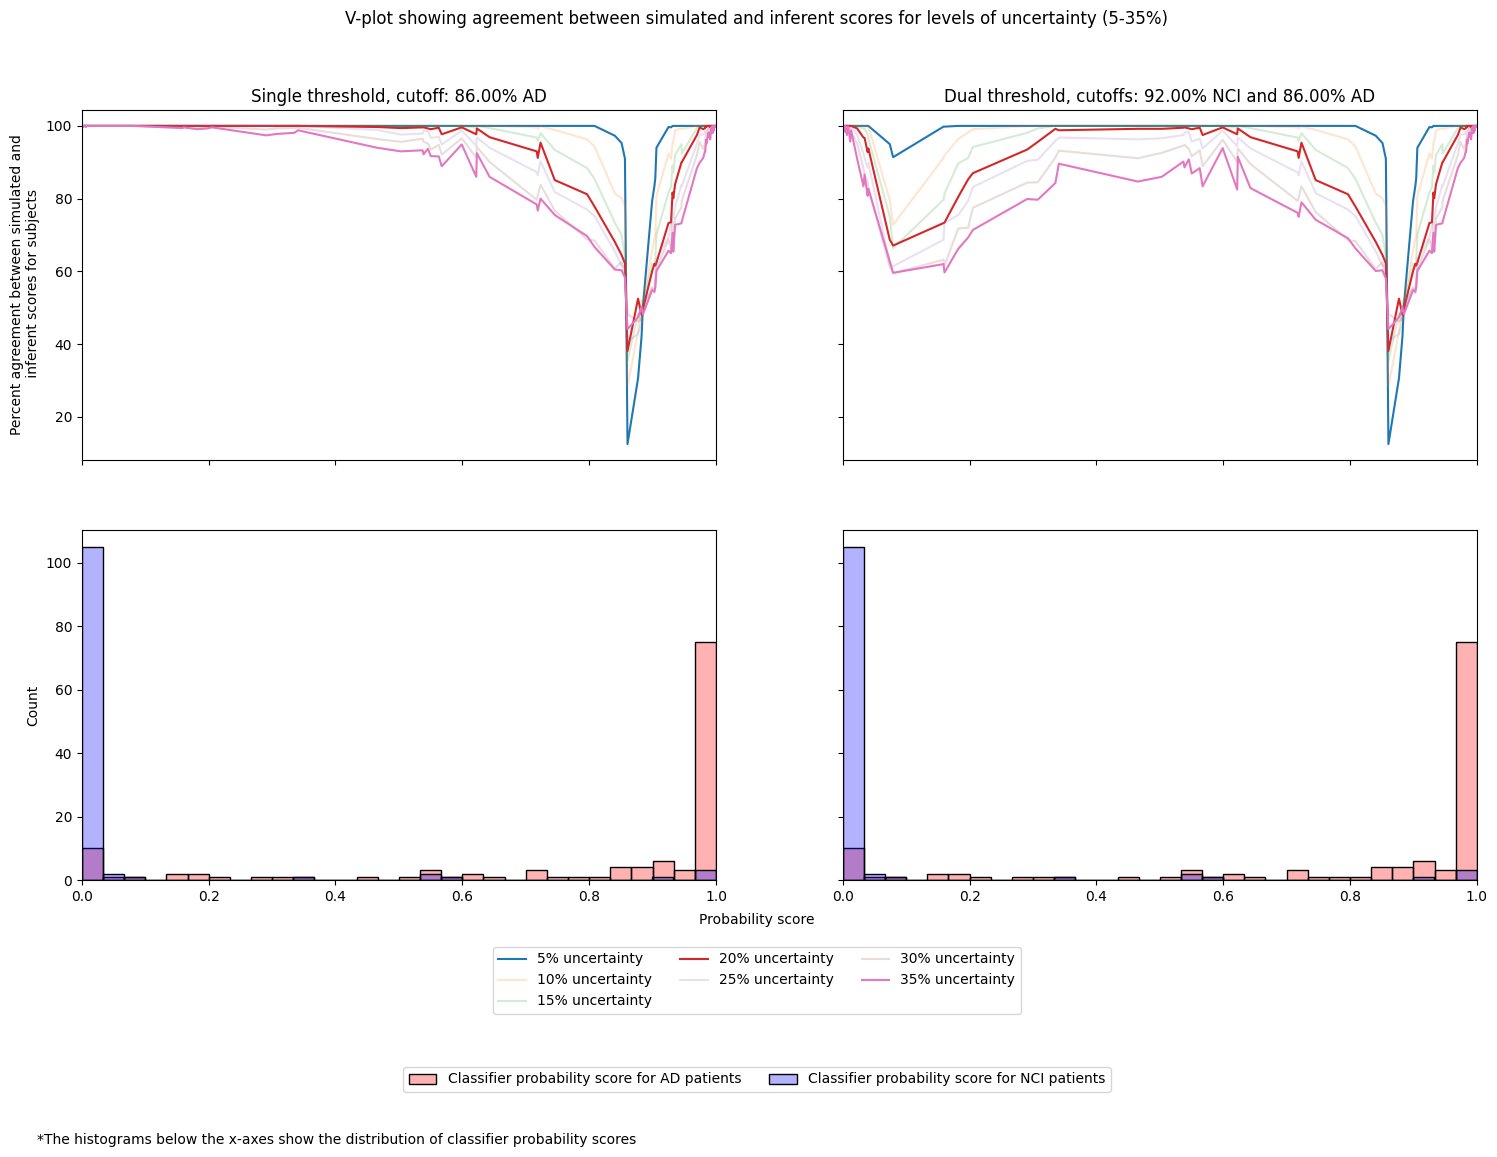

In [31]:
ad_probs = gt_probs[pathos[pathos["Disease"] == "AD"].index]
nci_probs = gt_probs[pathos[pathos["Disease"] == "NCI"].index]

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 2, height_ratios=[1, 1])
fig.add_subplot(gs[0])
plot_v_plot(
    single_thres_subj_wise_agreement,
    gt_probs,
    uncertainties,
    f"Single threshold, cutoff: {single_thres * 100:.2f}% AD",
    False,
    False,
)
plt.xlim([0.0, 1.0])
plt.ylabel("Percent agreement between simulated and\n inferent scores for subjects")
plt.gca().set_xticklabels([])

fig.add_subplot(gs[1])
plot_v_plot(
    dual_thres_subj_wise_agreement,
    gt_probs,
    uncertainties,
    f"Dual threshold, cutoffs: {(1 - dual_thres_low) * 100:.2f}% NCI and {dual_thres_high * 100:.2f}% AD",
    False,
    False,
)
plt.xlim([0.0, 1.0])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylabel("")
leg_handles, leg_labels = plt.gca().get_legend_handles_labels()

for i in [3, 4]:
    fig.add_subplot(gs[i - 1])
    sns.histplot(
        ad_probs,
        color="r",
        bins=30,
        label="Classifier probability score for AD patients",
        fill=True,
        alpha=0.3,
    )
    sns.histplot(
        nci_probs,
        color="b",
        bins=30,
        label="Classifier probability score for NCI patients",
        fill=True,
        alpha=0.3,
    )
    plt.xlim([0.0, 1.0])
    if i == 4:
        plt.gca().set_yticklabels([])
        plt.ylabel("")
leg_handles_2, leg_labels_2 = plt.gca().get_legend_handles_labels()

fig.legend(
    leg_handles,
    leg_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=len(uncertainties) // 2,
)
fig.legend(
    leg_handles_2,
    leg_labels_2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.07),
    ncol=len(uncertainties) // 2,
)
fig.text(0.5, 0.07, "Probability score", va="center", ha="center")
fig.suptitle(
    "V-plot showing agreement between simulated and inferent scores for levels of uncertainty (5-35%)"
)
fig.text(
    0.1,
    -0.15,
    "*The histograms below the x-axes show the distribution of classifier probability scores",
    ha="left",
    va="center",
)

### Preliminary observations

- RNA-Seq Measurement Uncertainty impacts differential classification predominantly at the classifier threshold.
- Filtering out genes with low mean TPMs decreases the percentage of both AD and NCI subjects whose diagnostic classification changes when at least 10% of simulations mismatch. 
- These low-expression genes are a source of classification instability under uncertainty which need to be taken into account when building diagnostic classifications.
- For a diagnostic classifier with two thresholds, 
    - An initial lab result might suggest a wait and watch approach.
    - The demonstration of near-certain reclassification under typical measurement noise for this specific patient's result acts like a diagnostic stress test (i.e revealing high instability). 

### References

1. Beaver et al. "An FDA Perspective on the Regulatory Implications of Complex Signatures to Predict Response to Targeted Therapies." _Clin Cancer Res. 2017 Mar 15;23(6):1368-1372._
2. Braga and Panteghini "The utility of measurement uncertainty in medical laboratories" _Clin Chem Lab Med 2020; 58(9):1407-1413_.
3. Law, Charity W., et al. "voom: Precision weights unlock linear model analysis tools for RNA-seq read counts." _Genome biology 15 (2014): 1-17_.
4. Petraco, Ricardo, et al. "Effects of disease severity distribution on the performance of quantitative diagnostic methods and proposal of a novel ‘V-plot’methodology to display accuracy values." _Open Heart 5.1 (2018): e000663_.
5. Plebani et al. "Measurement uncertainty: light in the shadows" _Clin Chem Lab Med 2020; 58(9):1381-1383_.
6. Song et al. "Anvil – System Architecture and Experiences from Deployment and Early User Operations" _PEARC July (2022)_.
7. Theodorsson E. "Uncertainty in Measurement and Total Error: Tools for Coping with Diagnostic Uncertainty." _Clin Lab Med. 2017 Mar;37(1):15-34_.
8. Toden et al. "Noninvasive characterization of Alzheimer's disease by circulating, cell-free messenger RNA next-generation sequencing." _Sci Adv. 2020 Dec 9;6(50):eabb1654_.
9. Tong et al. "Impact of RNA-seq data analysis algorithms on gene expression estimation and downstream prediction." _Sci Rep. 2020 Oct 21;10(1):17925_.